# Imports

In [1]:
import numpy as np

In [2]:
from src.convolution.numerical import convolution
from src.spectrum import (
    LinealEnergySpectrum,
    SpectrumData,
    SpectrumValueType,
    SpecificEnergySpectrum,
    specific_energy_spectum,
)
from src.paths import project_dir

In [3]:
# plotting
import matplotlib

%matplotlib inline
import matplotlib.pylab as plt

In [4]:
!python -V

Python 3.9.8


# Single event spectra for low energy photons

## Raw Data

Fig 4.8b from P. Olko PhD thesis, panel for 1 um

In [5]:
spectrum_y_f1_raw = LinealEnergySpectrum.from_csv(
    project_dir / "data" / "interim" / "Xrays_12keV_0.5um_ydy.csv",
    delimiter=",",
    value_type=SpectrumValueType.ydy,
)
spectrum_y_f1_raw.norm

0.9999999999999997

## f1 y spectrum

In [6]:
spectrum_y_f1 = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=spectrum_y_f1_raw.y,
        bin_values_freq_times_x=spectrum_y_f1_raw.yfy.clip(min=0),
    )
)

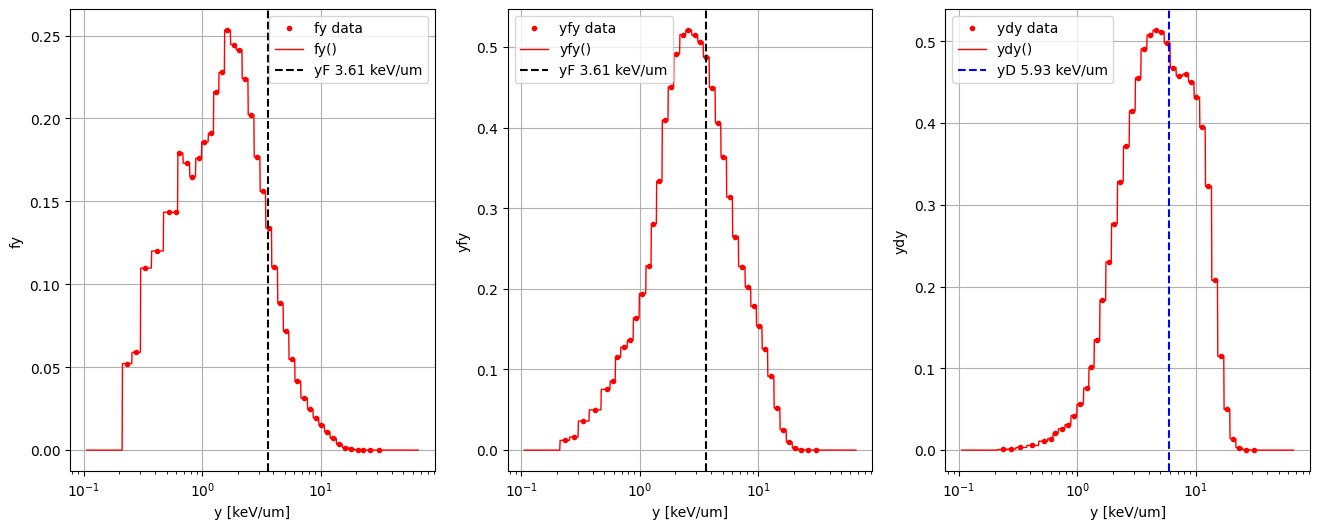

In [7]:
y_kev_um = np.geomspace(
    start=spectrum_y_f1.data.bin_edges[0] / 2,
    stop=spectrum_y_f1.data.bin_edges[-1] * 2,
    num=1000,
)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].plot(spectrum_y_f1.y, spectrum_y_f1.fy, ".", label="fy data", color="r")
ax[0].plot(
    y_kev_um,
    spectrum_y_f1.data.bin_values(y_kev_um, spectrum_value_type=SpectrumValueType.fy),
    label="fy()",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[0].axvline(
    spectrum_y_f1.yF,
    color="k",
    linestyle="--",
    label=f"yF {spectrum_y_f1.yF:2.2f} keV/um",
)
ax[0].set_ylabel("fy")
ax[1].plot(spectrum_y_f1.y, spectrum_y_f1.yfy, ".", label="yfy data", color="r")
ax[1].plot(
    y_kev_um,
    spectrum_y_f1.data.bin_values(y_kev_um, spectrum_value_type=SpectrumValueType.yfy),
    label="yfy()",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[1].axvline(
    spectrum_y_f1.yF,
    color="k",
    linestyle="--",
    label=f"yF {spectrum_y_f1.yF:2.2f} keV/um",
)
ax[1].set_ylabel("yfy")
ax[2].plot(spectrum_y_f1.y, spectrum_y_f1.ydy, ".", label="ydy data", color="r")
ax[2].plot(
    y_kev_um,
    spectrum_y_f1.data.bin_values(y_kev_um, spectrum_value_type=SpectrumValueType.ydy),
    label="ydy()",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[2].axvline(
    spectrum_y_f1.yD,
    color="b",
    linestyle="--",
    label=f"yD {spectrum_y_f1.yD:2.2f} keV/um",
)
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

## f1 z spectrum

In [8]:
site_diam_um = 1.0
spectrum_z_f1 = specific_energy_spectum(spectrum_y_f1, site_diam_um=site_diam_um)

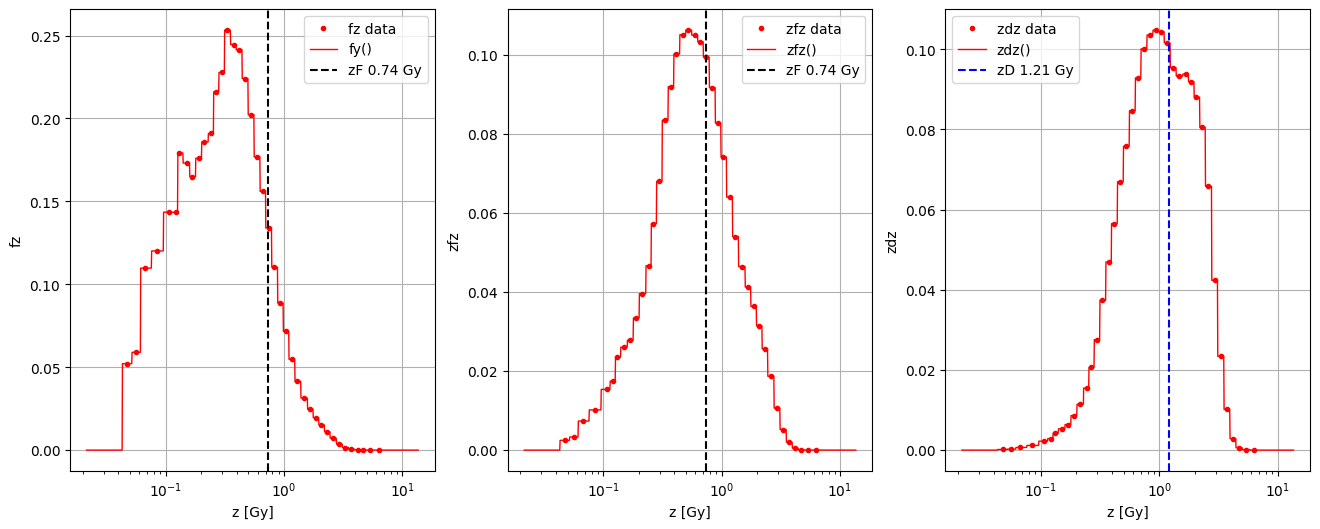

In [9]:
z_Gy = np.geomspace(
    start=spectrum_z_f1.data.bin_edges[0] / 2,
    stop=spectrum_z_f1.data.bin_edges[-1] * 2,
    num=1000,
)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].plot(spectrum_z_f1.z, spectrum_z_f1.fz, ".", label="fz data", color="r")
ax[0].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz),
    label="fy()",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[0].axvline(
    spectrum_z_f1.zF, color="k", linestyle="--", label=f"zF {spectrum_z_f1.zF:2.2f} Gy"
)
ax[0].set_ylabel("fz")
ax[1].plot(spectrum_z_f1.z, spectrum_z_f1.zfz, ".", label="zfz data", color="r")
ax[1].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.yfy),
    label="zfz()",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[1].axvline(
    spectrum_z_f1.zF, color="k", linestyle="--", label=f"zF {spectrum_z_f1.zF:2.2f} Gy"
)
ax[1].set_ylabel("zfz")
ax[2].plot(spectrum_z_f1.z, spectrum_z_f1.zdz, ".", label="zdz data", color="r")
ax[2].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.ydy),
    label="zdz()",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[2].axvline(
    spectrum_z_f1.zD, color="b", linestyle="--", label=f"zD {spectrum_z_f1.zD:2.2f} Gy"
)
ax[2].set_ylabel("zdz")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("z [Gy]")
    a.legend()

## convolution of f1 y

In [10]:
# we apply convolution on f(y), not on yfy or ydy
spectrum_y_f1_function = lambda x: spectrum_y_f1.data.bin_value(
    x, spectrum_value_type=SpectrumValueType.fy
)

expected_f2_domain = (
    spectrum_y_f1.data.bin_edges[0] * 2,
    spectrum_y_f1.data.bin_edges[-1] * 2.0,
)
yvalues_for_f2_convolution = np.geomspace(
    start=expected_f2_domain[0], stop=expected_f2_domain[1], num=50
)

convolution_integration_limits = (
    spectrum_y_f1.data.bin_edges[0] / 2,
    spectrum_y_f1.data.bin_edges[-1] * 2,
)
integral_kwargs = {
    "limit": 800,
    "points": np.geomspace(*convolution_integration_limits, 400),
}
spectrum_y_f2_values_and_errors = [
    convolution(
        spectrum_y_f1_function,
        lower_limit=convolution_integration_limits[0],
        upper_limit=convolution_integration_limits[1],
        kwargs=integral_kwargs,
    )(y)
    for y in yvalues_for_f2_convolution
]

/home/grzanka/workspace/widma/src/convolution/numerical.py:36: IntegrationWarning: The maximum number of subdivisions (800) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(func=integrand, a=lower_limit, b=upper_limit, args=(y, integrand_args), *args, **kwargs)


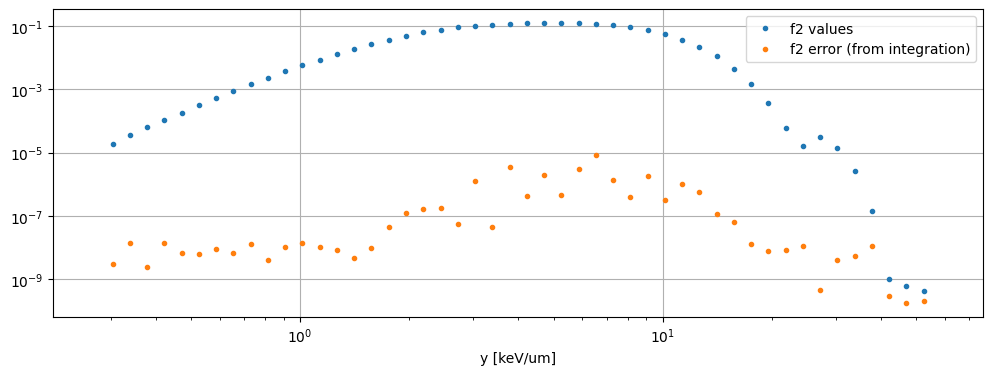

In [11]:
# by comparing the integration error with f2 values we check the numerical integration accuracy
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.plot(
    yvalues_for_f2_convolution,
    [item[0] for item in spectrum_y_f2_values_and_errors],
    ".",
    label="f2 values",
)
ax.plot(
    yvalues_for_f2_convolution,
    [item[1] for item in spectrum_y_f2_values_and_errors],
    ".",
    label="f2 error (from integration)",
)
ax.grid()
ax.set_xlabel("y [keV/um]")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

## f2 y spectrum

In [12]:
spectrum_y_f2 = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=yvalues_for_f2_convolution,
        bin_values_freq=np.array([item[0] for item in spectrum_y_f2_values_and_errors]),
    )
)

In [13]:
spectrum_y_f2.yF, spectrum_y_f2.yD

(6.654154427498713, 8.115532443525396)

In [14]:
# check if yF is doubled
spectrum_y_f2.yF / spectrum_y_f1.yF

2.0034668873852466

In [15]:
# check norm
spectrum_y_f2.norm

0.9889273413145863

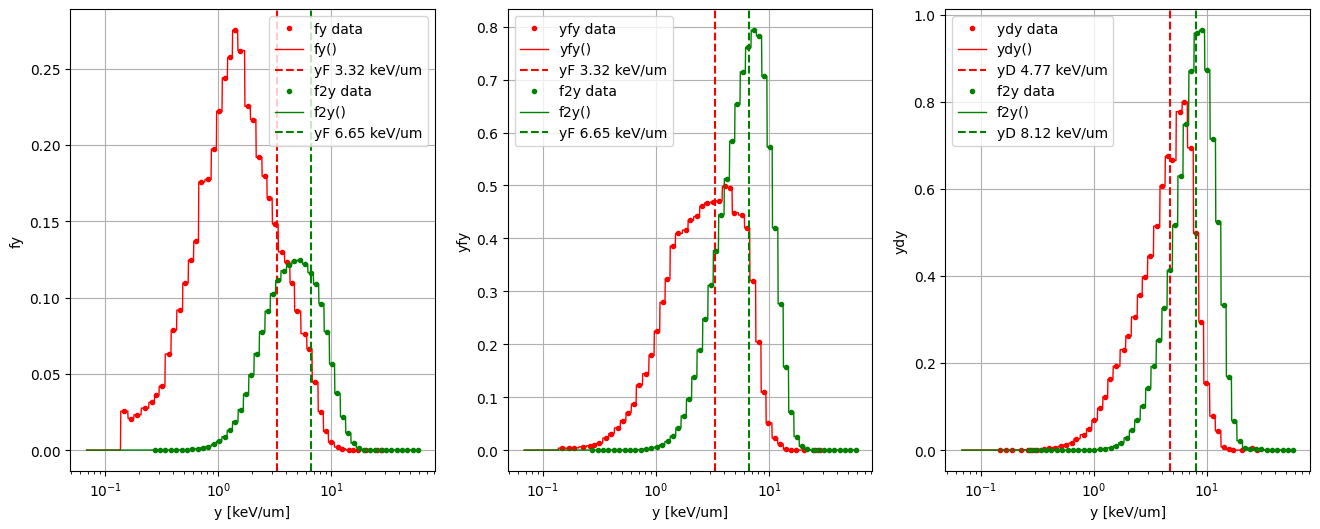

In [16]:
y_kev_um = np.geomspace(
    start=spectrum_y_f1.data.bin_edges[0] / 2,
    stop=spectrum_y_f1.data.bin_edges[-1] * 2,
    num=1000,
)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].plot(spectrum_y_f1.y, spectrum_y_f1.fy, ".", label="fy data", color="r")
ax[0].plot(
    y_kev_um,
    spectrum_y_f1.data.bin_values(y_kev_um, spectrum_value_type=SpectrumValueType.fy),
    label="fy()",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[0].axvline(
    spectrum_y_f1.yF,
    color="r",
    linestyle="--",
    label=f"yF {spectrum_y_f1.yF:2.2f} keV/um",
)
ax[0].plot(spectrum_y_f2.y, spectrum_y_f2.fy, ".", label="f2y data", color="g")
ax[0].plot(
    y_kev_um,
    spectrum_y_f2.data.bin_values(y_kev_um, spectrum_value_type=SpectrumValueType.fy),
    label="f2y()",
    linestyle="-",
    linewidth=1,
    color="g",
)
ax[0].axvline(
    spectrum_y_f2.yF,
    color="g",
    linestyle="--",
    label=f"yF {spectrum_y_f2.yF:2.2f} keV/um",
)
ax[0].set_ylabel("fy")
ax[1].plot(spectrum_y_f1.y, spectrum_y_f1.yfy, ".", label="yfy data", color="r")
ax[1].plot(
    y_kev_um,
    spectrum_y_f1.data.bin_values(y_kev_um, spectrum_value_type=SpectrumValueType.yfy),
    label="yfy()",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[1].axvline(
    spectrum_y_f1.yF,
    color="r",
    linestyle="--",
    label=f"yF {spectrum_y_f1.yF:2.2f} keV/um",
)
ax[1].plot(spectrum_y_f2.y, spectrum_y_f2.yfy, ".", label="f2y data", color="g")
ax[1].plot(
    y_kev_um,
    spectrum_y_f2.data.bin_values(y_kev_um, spectrum_value_type=SpectrumValueType.yfy),
    label="f2y()",
    linestyle="-",
    linewidth=1,
    color="g",
)
ax[1].axvline(
    spectrum_y_f2.yF,
    color="g",
    linestyle="--",
    label=f"yF {spectrum_y_f2.yF:2.2f} keV/um",
)
ax[1].set_ylabel("yfy")
ax[2].plot(spectrum_y_f1.y, spectrum_y_f1.ydy, ".", label="ydy data", color="r")
ax[2].plot(
    y_kev_um,
    spectrum_y_f1.data.bin_values(y_kev_um, spectrum_value_type=SpectrumValueType.ydy),
    label="ydy()",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[2].axvline(
    spectrum_y_f1.yD,
    color="r",
    linestyle="--",
    label=f"yD {spectrum_y_f1.yD:2.2f} keV/um",
)
ax[2].plot(spectrum_y_f2.y, spectrum_y_f2.ydy, ".", label="f2y data", color="g")
ax[2].plot(
    y_kev_um,
    spectrum_y_f2.data.bin_values(y_kev_um, spectrum_value_type=SpectrumValueType.ydy),
    label="f2y()",
    linestyle="-",
    linewidth=1,
    color="g",
)
ax[2].axvline(
    spectrum_y_f2.yD,
    color="g",
    linestyle="--",
    label=f"yD {spectrum_y_f2.yD:2.2f} keV/um",
)
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    # a.set_yscale('log')
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

## f2 z spectrum

In [17]:
spectrum_z_f2 = SpecificEnergySpectrum(
    data=SpectrumData(
        bin_centers=0.204 * spectrum_y_f2.y / site_diam_um**2,
        bin_values_freq=spectrum_y_f2.fy,
    )
)

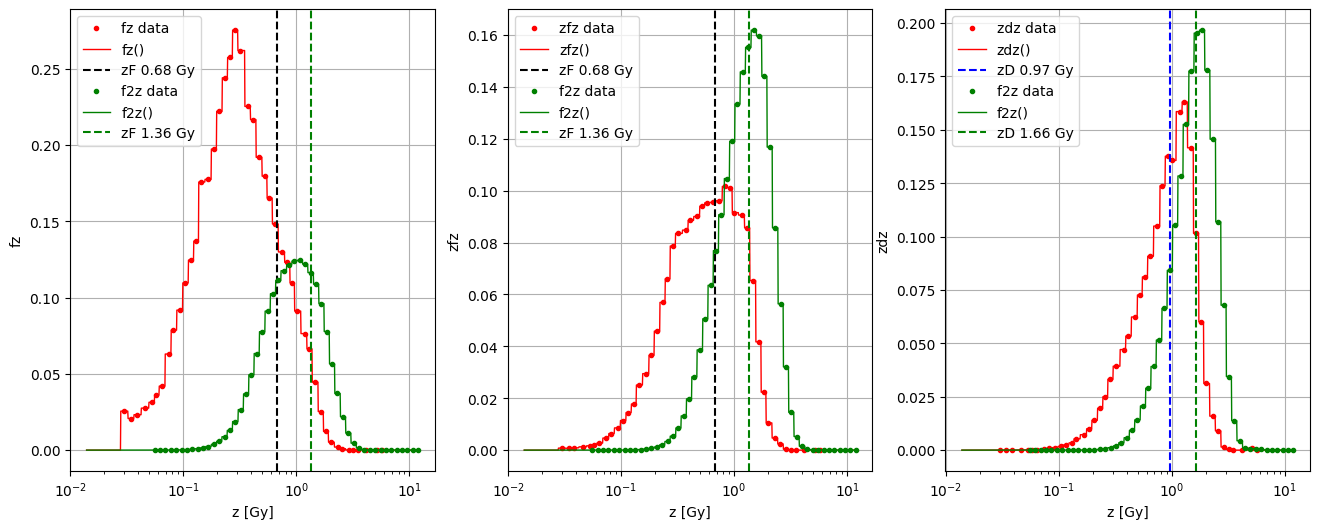

In [18]:
z_Gy = np.geomspace(
    start=spectrum_z_f1.data.bin_edges[0] / 2,
    stop=spectrum_z_f1.data.bin_edges[-1] * 2,
    num=1000,
)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].plot(spectrum_z_f1.z, spectrum_z_f1.fz, ".", label="fz data", color="r")
ax[0].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz),
    label="fz()",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[0].axvline(
    spectrum_z_f1.zF, color="k", linestyle="--", label=f"zF {spectrum_z_f1.zF:2.2f} Gy"
)
ax[0].plot(spectrum_z_f2.z, spectrum_z_f2.fz, ".", label="f2z data", color="g")
ax[0].plot(
    z_Gy,
    spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fy),
    label="f2z()",
    linestyle="-",
    linewidth=1,
    color="g",
)
ax[0].axvline(
    spectrum_z_f2.zF, color="g", linestyle="--", label=f"zF {spectrum_z_f2.zF:2.2f} Gy"
)
ax[0].set_ylabel("fz")
ax[1].plot(spectrum_z_f1.z, spectrum_z_f1.zfz, ".", label="zfz data", color="r")
ax[1].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.yfy),
    label="zfz()",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[1].axvline(
    spectrum_z_f1.zF, color="k", linestyle="--", label=f"zF {spectrum_z_f1.zF:2.2f} Gy"
)
ax[1].plot(spectrum_z_f2.z, spectrum_z_f2.zfz, ".", label="f2z data", color="g")
ax[1].plot(
    z_Gy,
    spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.yfy),
    label="f2z()",
    linestyle="-",
    linewidth=1,
    color="g",
)
ax[1].axvline(
    spectrum_z_f2.zF, color="g", linestyle="--", label=f"zF {spectrum_z_f2.zF:2.2f} Gy"
)
ax[1].set_ylabel("zfz")
ax[2].plot(spectrum_z_f1.z, spectrum_z_f1.zdz, ".", label="zdz data", color="r")
ax[2].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.ydy),
    label="zdz()",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[2].axvline(
    spectrum_z_f1.zD, color="b", linestyle="--", label=f"zD {spectrum_z_f1.zD:2.2f} Gy"
)
ax[2].plot(spectrum_z_f2.z, spectrum_z_f2.zdz, ".", label="f2z data", color="g")
ax[2].plot(
    z_Gy,
    spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.ydy),
    label="f2z()",
    linestyle="-",
    linewidth=1,
    color="g",
)
ax[2].axvline(
    spectrum_z_f2.zD, color="g", linestyle="--", label=f"zD {spectrum_z_f2.zD:2.2f} Gy"
)
ax[2].set_ylabel("zdz")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("z [Gy]")
    a.legend()

# Dose dependent spectra

In [19]:
D_Gy = 0.05  # Gy (50 mGy)
D_Gy

0.05

In [20]:
# mean number of events in the site
n = D_Gy / spectrum_z_f1.zF
n

0.07379537266258811

In [21]:
# In microdosimetry the low dose is the dose at which sensitive site is affected just once.
# However, since the cells are hit independently, even at low doses target can be hit two or
# more times. Therefore, the statistical criterion for low dose is that 90% of the affected targets
# are hit just once. This happens when D ≤ 0.2 zF .

In [22]:
D_Gy, 0.2 * spectrum_z_f1.zF

(0.05, 0.13550985162338886)

In [23]:
# trying to evaluate n f1(z) + n^2/2 f2(z), we are missing here f0(z)

In [24]:
z_Gy = np.geomspace(start=0.1, stop=10, num=80)
spectrum_z_fn_values = n * spectrum_z_f1.data.bin_values(
    z_Gy, spectrum_value_type=SpectrumValueType.fz
) + n**2 / 2 * spectrum_z_f2.data.bin_values(
    z_Gy, spectrum_value_type=SpectrumValueType.fz
)
spectrum_z_fn_values *= np.exp(-n)

In [25]:
spectrum_z_fn = SpecificEnergySpectrum(
    data=SpectrumData(bin_centers=z_Gy, bin_values_freq=spectrum_z_fn_values)
)

In [26]:
spectrum_z_fn.zF, spectrum_z_fn.zD

(0.7139175121724709, 1.0196434965687684)

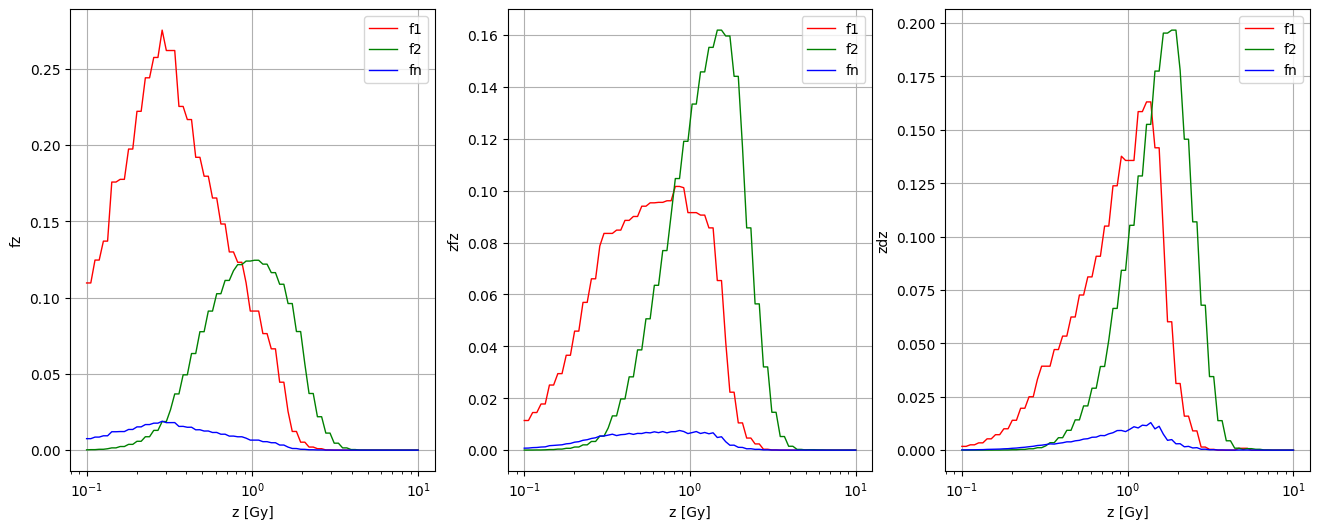

In [27]:
z_Gy = np.geomspace(start=0.1, stop=10, num=80)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz),
    label="f1",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[0].plot(
    z_Gy,
    spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fy),
    label="f2",
    linestyle="-",
    linewidth=1,
    color="g",
)
ax[0].plot(
    z_Gy,
    spectrum_z_fn.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz),
    label="fn",
    linestyle="-",
    linewidth=1,
    color="b",
)
ax[0].set_ylabel("fz")
ax[1].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.yfy),
    label="f1",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[1].plot(
    z_Gy,
    spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.yfy),
    label="f2",
    linestyle="-",
    linewidth=1,
    color="g",
)
ax[1].plot(
    z_Gy,
    spectrum_z_fn.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.yfy),
    label="fn",
    linestyle="-",
    linewidth=1,
    color="b",
)
ax[1].set_ylabel("zfz")
ax[2].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.ydy),
    label="f1",
    linestyle="-",
    linewidth=1,
    color="r",
)
ax[2].plot(
    z_Gy,
    spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.ydy),
    label="f2",
    linestyle="-",
    linewidth=1,
    color="g",
)
ax[2].plot(
    z_Gy,
    spectrum_z_fn.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.ydy),
    label="fn",
    linestyle="-",
    linewidth=1,
    color="b",
)
ax[2].set_ylabel("zdz")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("z [Gy]")
    a.legend()